In [ ]:
from sctoolbox.utils.jupyter import bgcolor, _compare_version

# change the background of input cells
bgcolor("PowderBlue", select=[2, 4])

nb_name = "0B_velocity_analysis.ipynb"

_compare_version(nb_name)

# 0B - Velocity Analysis
<hr style="border:2px solid black"> </hr>

## 1 - Description

**Note: Requires notebook 04_clustering to be run prior to this notebook.**

This notebook can be used for velocity analysis of scRNA data using the scvelo package.  
Most analysis steps are directly taken from the scvelo <a href=https://scvelo.readthedocs.io/en/stable/VelocityBasics.html>documentation</a>
                                                                    
### 1.1 Velocity Analysis
RNA velocity describes the rate of gene expression change for an individual gene at a given time point based on the ratio of its spliced and unspliced messenger RNA (mRNA).
A significantly higher unspliced mRNA count for a specific gene indicates that the future cell state would likely show an expression increase. On the other hand, a significantly higher spliced mRNA count for a specific gene indicates that the future cell state would likely show a depletion of expression.

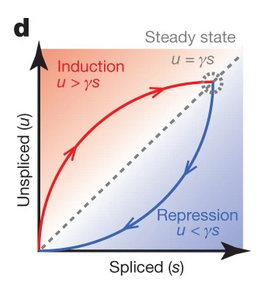
<span style="color:lightgrey">Image source: La Manno, G., Soldatov, R., Zeisel, A. et al. RNA velocity of single cells. Nature 560, 494–498 (2018). https://doi.org/10.1038/s41586-018-0414-6</span>.

------------

## 2 - Setup

In [ ]:
from sctoolbox import settings
import scvelo as scv
import scanpy as sc
import pandas as pd
import sctoolbox.utils as utils
settings.settings_from_config("config.yaml", key="0B")
scv.settings.figdir = settings.figure_dir

------------

## 3 - Load anndata

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [ ]:
# Input filename
last_notebook_adata = "anndata_4.h5ad"

___

In [ ]:
adata = utils.adata.load_h5ad(last_notebook_adata)

with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata)
    display(adata.obs)
    display(adata.var)

___

## 4 - General input

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [ ]:
# Path to vdata file
vdata_path = ""
# Column containing final clustering
clustering = "clustering"
# Embedding umap/tsne
embedding = "umap"
# Number of pcs
n_pcs = 10

# Genes of interest
goi = []

# Number of threads
threads = 4

### Plotting parameters ###

## Velocity embeding stream
arrow_color = "k"
stream_arrow_size = 1

## Velocity embedding
## arrow size needs to be <= arrow_length
arrow_length = 3
arrow_size = 3

## Velocity graph
velo_graph_threshold = 0.1

------------

## 5 - Check for spliced/unspliced/ambiguous layer

In [ ]:
layer = set(adata.layers.keys())
if not {"spliced", "unspliced"}.issubset(layer):
    
    cell_count = adata.shape[0]
    
    # load vdata
    vdata = sc.read(filename=vdata_path)
    
    if len(adata.obs.index.union(vdata.obs.index)) == 0:
        raise ValueError("No overlap between cell barcodes found. Please check adata.obs/vdata.obs.")

    # Merge adata vs vdata
    scv.utils.merge(adata, vdata, copy=False)
    print(f"{adata.shape[0]}/{cell_count} ({int((adata.shape[0]/cell_count)*100)}%) cells remain after merging adata with vdata.")

------------

## 6 - Preprocessing

In [ ]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata, n_pcs=n_pcs)

------------

## 7 - Calculate velocity

In [ ]:
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata, n_jobs=threads)
scv.tl.velocity_confidence(adata)

------------

## 8 - Visualization
<hr style="border:2px solid black"> </hr>

### 8.1 - Proportion

In [ ]:
scv.pl.proportions(adata, groupby=clustering, save="velocity_proportion.pdf")

------------

### 8.2 - Embedding

In [ ]:
scv.pl.velocity_embedding_stream(adata,
                                 basis=embedding,
                                 color=clustering,
                                 arrow_color=arrow_color,
                                 arrow_size=stream_arrow_size,
                                 save="velocity_embeding_stream.pdf")

In [ ]:
scv.pl.velocity_embedding(adata, color=clustering, arrow_length=arrow_length, arrow_size=arrow_size, save="velocity_embeding.pdf")

------------

### 8.3 - Velocity length and confidence

The speed or rate of differentiation is given by the length of the velocity vector.  
The coherence of the vector field (i.e., how a velocity vector correlates with its neighboring velocities) provides a measure of confidence.

In [ ]:
keys = ['velocity_length', 'velocity_confidence']
scv.pl.scatter(adata, c=keys, cmap='coolwarm', save="velocity_confidence.pdf")

In [ ]:
df = adata.obs.groupby(clustering)[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

------------

### 8.4 - Velocity graph

In [ ]:
scv.pl.velocity_graph(adata, threshold=velo_graph_threshold, color=clustering)

------------

## 9 - Pseudotime - scVelo

In [ ]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

------------

## 10 - PAGA

In [ ]:
scv.tl.paga(adata, groups=clustering)
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

In [ ]:
scv.pl.paga(adata, basis=embedding, color=clustering, size=50, alpha=.1, min_edge_width=2, node_size_scale=1.5)

------------

## 11 - Velocity genes
<hr style="border:2px solid black"> </hr>

In [ ]:
scv.tl.rank_velocity_genes(adata, groupby=clustering, min_corr=.3)

In [ ]:
velocity_genes = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
velocity_genes.head()

------------

### 11.1 - Gene of interest

In [ ]:
if goi:
    scv.pl.velocity(adata, goi, ncols=2, save="velocity_goi.pdf")

In [ ]:
for col in velocity_genes.columns:
    genes = velocity_genes[col][:5]
    scv.pl.velocity(adata, genes, ncols=2, save=f"marker_velocity_genes_{col}.pdf")

------------

## 12 - Saving adata

In [ ]:
utils.adata.save_h5ad(adata, "anndata_0B.h5ad")

In [ ]:
settings.close_logfile()